In [9]:
test = False
if test:
    dates = '2019/[0-1][0-9]/01'
    parquet_file = '/cms/users/carizapo/test.parquet'
else:
    dates = '2019/[0-1][0-9]/[0-3][0-9]'
    parquet_file = '/cms/users/carizapo/full.parquet'

In [10]:
sc

<SparkContext master=yarn appName=pyspark_shell_swan>

In [11]:
spark

In [12]:
# execute this cell which downloads required libraries and put them in place
# Note: I modified it from the CMSSparkExample to remove dependencies that
# not longed requiered. 
import os
with open('env.sh', 'w') as ostream:
    ostream.write("""#!/bin/bash
wdir=$PWD/wdir
if [ -d $wdir ]; then
    rm -rf $wdir
fi
mkdir -p $wdir
cd $wdir
branch='Eos-dataset'
wget https://my.pcloud.com/publink/show?code=XZwzn97ZIoG4isDNO3b6SrTEUfQ1Y4E6bp9k -O ./avro-mapred.jar
wget "https://github.com/cronosnull/CMSSpark/archive/$branch.zip" -O ./master.zip
unzip ./master.zip 2> /dev/null
mv "CMSSpark-$branch" CMSSpark""")
!ls
!source ./env.sh
!ls
!cd wdir; ls



dataset_summary.csv  EOS Dataset from CMSSpark.ipynb  wdir
env.sh		     spark-warehouse
--2019-03-12 18:30:37--  https://my.pcloud.com/publink/show?code=XZwzn97ZIoG4isDNO3b6SrTEUfQ1Y4E6bp9k
Resolving my.pcloud.com (my.pcloud.com)... 74.120.8.14, 74.120.8.226, 74.120.9.89, ...
Connecting to my.pcloud.com (my.pcloud.com)|74.120.8.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43222 (42K) [text/html]
Saving to: ‘./avro-mapred.jar’

100%[======================================>] 43,222      --.-K/s   in 0.1s    

2019-03-12 18:30:38 (310 KB/s) - ‘./avro-mapred.jar’ saved [43222/43222]

--2019-03-12 18:30:38--  https://github.com/cronosnull/CMSSpark/archive/Eos-dataset.zip
Resolving github.com (github.com)... 140.82.118.4, 140.82.118.3
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/cronosnull/CMSSpark/zip/Eos-dataset [following]
--2019-03-12 18:30:38-- 

In [13]:
import os,sys
print(os.path.join(os.path.abspath('.'), 'wdir/CMSSpark/src/python'))
sys.path.append(os.path.join(os.path.abspath("."), 'wdir/CMSSpark/src/python'))

/eos/home-c/carizapo/SWAN_projects/EOS/wdir/CMSSpark/src/python


In [14]:
from CMSSpark.spark_utils import eos_tables, dbs_tables

In [15]:
##### Staging area ################
# THIS CELL IS ONLY USED TO MODIFY EOS TABLES, THAT SHOULD BE DEFINED IN SPARK UTILS 
def files(url,verbose):
    URI = sc._gateway.jvm.java.net.URI
    Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
    FileSystem = sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
    fs = FileSystem.get(URI("hdfs:///"), sc._jsc.hadoopConfiguration())
    l = fs.globStatus(Path(url))
    return l

def eos_tables(sqlContext,
        hdir='hdfs:///project/monitoring/archive/eos/logs/reports/cms',
        date=None, verbose=False):
    """
    Parse EOS HDFS records. This data set comes from EOS servers at CERN. Data
    is send directly by the EOS team, reading the EOS logs and sending them
    into the MONIT infrastructure.
    
    Use https://twiki.cern.ch/twiki/bin/view/ITAnalyticsWorkingGroup/EosFileAccessLogs as data dictionary. 

    Example of EOS JSON record on HDFS
    {"data":"\"log=9e7436fe-1d8e-11e7-ba07-a0369f1fbf0c&path=/store/mc/PhaseISpring17GS/MinBias_TuneCUETP8M1_13TeV-pythia8/GEN-SIM/90X_upgrade2017_realistic_v20-v1/50000/72C78841-2110-E711-867F-F832E4CC4D39.root&ruid=8959&rgid=1399&td=nobody.693038:472@fu-c2e05-24-03-daq2fus1v0--cms&host=p05798818q44165.cern.ch&lid=1048850&fid=553521212&fsid=18722&ots=1491788403&otms=918&cts=1491789688&ctms=225&rb=19186114&rb_min=104&rb_max=524288&rb_sigma=239596.05&wb=0&wb_min=0&wb_max=0&wb_sigma=0.00&sfwdb=7576183815&sbwdb=6313410471&sxlfwdb=7575971197&sxlbwdb=6313300667&nrc=72&nwc=0&nfwds=24&nbwds=10&nxlfwds=12&nxlbwds=4&rt=9130.44&wt=0.00&osize=3850577700&csize=3850577700&sec.prot=gsi&sec.name=cmsprd&sec.host=cms-ucsrv-c2f46-32-07.cern.ch&sec.vorg=&sec.grps=&sec.role=&sec.info=/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=amaltaro/CN=718748/CN=Alan Malta Rodrigues&sec.app=\"","metadata":{"host":"eoscms-srv-m1.cern.ch","kafka_timestamp":1491789692305,"partition":"14","path":"cms","producer":"eos","timestamp":1491789689562,"topic":"eos_logs","type":"reports","type_prefix":"logs"}}
    # in 2019 we have the following structure
    {"data":{"eos.csize":"49834","eos.ctms":"177","eos.cts":"1548009771","eos.fid":"1282182923","eos.fsid":"8953","eos.fstpath":"/data08/0001f4da/4c6c8f0b","eos.host":"lxfsrf65c02.cern.ch","eos.lid":"1048850","eos.log":"30a723b0-1ce3-11e9-b49d-a0369f1fba7c","eos.nbwds":"0","eos.nfwds":"0","eos.nrc":"0","eos.nwc":"3","eos.nxlbwds":"0","eos.nxlfwds":"0","eos.osize":"0","eos.otms":"109","eos.ots":"1548009771","eos.path":"/eos/cms/store/unified/www/joblogs/vlimant_ACDC0_task_SUS-RunIISummer16FSPremix-00090__v1_T_190118_174333_8486/139/SUS-RunIISummer16FSPremix-00090_0/f585f0eb-1e6b-4722-8266-5254e7975115-72-1-logArchive/job/WMTaskSpace/cmsRun1/lheevent/process/madevent/SubProcesses/P3_gq_urdlxgq/G168.08/run1_app.log","eos.rb":"0","eos.rb_max":"0","eos.rb_min":"0","eos.rb_sigma":"0.00","eos.rc_max":"0","eos.rc_min":"0","eos.rc_sigma":"0.00","eos.rc_sum":"0","eos.rgid":"1399","eos.rs_op":"0","eos.rsb_max":"0","eos.rsb_min":"0","eos.rsb_sigma":"0.00","eos.rsb_sum":"0","eos.rt":"0.00","eos.ruid":"103074","eos.rv_op":"0","eos.rvb_max":"0","eos.rvb_min":"0","eos.rvb_sigma":"0.00","eos.rvb_sum":"0","eos.rvt":"0.00","eos.sbwdb":"0","eos.sec.app":"fuse","eos.sec.host":"vocms0268.ipv6.cern.ch","eos.sec.name":"vlimant","eos.sec.prot":"krb5","eos.sfwdb":"0","eos.sxlbwdb":"0","eos.sxlfwdb":"0","eos.td":"daemon.23360:250@lxfsre50c03","eos.wb":"0","eos.wb_max":"0","eos.wb_min":"0","eos.wb_sigma":"0.00","eos.wt":"0.07","raw":"log=30a723b0-1ce3-11e9-b49d-a0369f1fba7c&path=/eos/cms/store/unified/www/joblogs/vlimant_ACDC0_task_SUS-RunIISummer16FSPremix-00090__v1_T_190118_174333_8486/139/SUS-RunIISummer16FSPremix-00090_0/f585f0eb-1e6b-4722-8266-5254e7975115-72-1-logArchive/job/WMTaskSpace/cmsRun1/lheevent/process/madevent/SubProcesses/P3_gq_urdlxgq/G168.08/run1_app.log&fstpath=/data08/0001f4da/4c6c8f0b&ruid=103074&rgid=1399&td=daemon.23360:250@lxfsre50c03&host=lxfsrf65c02.cern.ch&lid=1048850&fid=1282182923&fsid=8953&ots=1548009771&otms=109&cts=1548009771&ctms=177&nrc=0&nwc=3&rb=0&rb_min=0&rb_max=0&rb_sigma=0.00&rv_op=0&rvb_min=0&rvb_max=0&rvb_sum=0&rvb_sigma=0.00&rs_op=0&rsb_min=0&rsb_max=0&rsb_sum=0&rsb_sigma=0.00&rc_min=0&rc_max=0&rc_sum=0&rc_sigma=0.00&wb=0&wb_min=0&wb_max=0&wb_sigma=0.00&sfwdb=0&sbwdb=0&sxlfwdb=0&sxlbwdb=0&nfwds=0&nbwds=0&nxlfwds=0&nxlbwds=0&rt=0.00&rvt=0.00&wt=0.07&osize=0&csize=49834&sec.prot=krb5&sec.name=vlimant&sec.host=vocms0268.ipv6.cern.ch&sec.vorg=&sec.grps=&sec.role=&sec.info=&sec.app=fuse","real_timestamp":"1548009771000"},"metadata":{"_id":"e2a22c6d-77b3-dd33-d5d8-3357c1988e49","host":"eoscms-srv-m1.cern.ch","json":"true","kafka_timestamp":1548009773721,"partition":"19","path":"cms","producer":"eos","timestamp":1548009771000,"topic":"eos_logs","type":"reports","type_prefix":"logs"}}
    # in 2019 we have the following structure, version II after I reported eos prefix issue
    {"data":{"csize":"853699786","ctms":"939","cts":"1549043141","eos_host":"p06253937y92607.cern.ch","eos_path":"/eos/cms/store/cmst3/group/wmass/w-helicity-13TeV/trees/TREES_electrons_1l_V6_TINY/friends/tree_Friend_WJetsToLNu_NLO_part1.root","fid":"1126583180","fsid":"20546","fstpath":"/data07/0001b812/43264b8c","lid":"1048850","log":"287544b4-2649-11e9-abe8-a0369f1fba7c","nbwds":"145","nfwds":"195","nrc":"479","nwc":"0","nxlbwds":"144","nxlfwds":"143","osize":"853699786","otms":"479","ots":"1549043126","prot":"krb5","raw":"log=287544b4-2649-11e9-abe8-a0369f1fba7c&path=/eos/cms/store/cmst3/group/wmass/w-helicity-13TeV/trees/TREES_electrons_1l_V6_TINY/friends/tree_Friend_WJetsToLNu_NLO_part1.root&fstpath=/data07/0001b812/43264b8c&ruid=24421&rgid=1399&td=emanuele.81:510@b6644a93b5&host=p06253937y92607.cern.ch&lid=1048850&fid=1126583180&fsid=20546&ots=1549043126&otms=479&cts=1549043141&ctms=939&nrc=479&nwc=0&rb=41276444&rb_min=294&rb_max=326196&rb_sigma=101487.35&rv_op=0&rvb_min=0&rvb_max=0&rvb_sum=0&rvb_sigma=0.00&rs_op=0&rsb_min=0&rsb_max=0&rsb_sum=0&rsb_sigma=0.00&rc_min=0&rc_max=0&rc_sum=0&rc_sigma=0.00&wb=0&wb_min=0&wb_max=0&wb_sigma=0.00&sfwdb=3019121271&sbwdb=2233253538&sxlfwdb=3017497429&sxlbwdb=2233253338&nfwds=195&nbwds=145&nxlfwds=143&nxlbwds=144&rt=48.11&rvt=0.00&wt=0.00&osize=853699786&csize=853699786&sec.prot=krb5&sec.name=emanuele&sec.host=b6644a93b5.cern.ch&sec.vorg=&sec.grps=&sec.role=&sec.info=&sec.app=","rb":"41276444","rb_max":"326196","rb_min":"294","rb_sigma":"101487.35","rc_max":"0","rc_min":"0","rc_sigma":"0.00","rc_sum":"0","real_timestamp":"1549043126000","rgid":"1399","rs_op":"0","rsb_max":"0","rsb_min":"0","rsb_sigma":"0.00","rsb_sum":"0","rt":"48.11","ruid":"24421","rv_op":"0","rvb_max":"0","rvb_min":"0","rvb_sigma":"0.00","rvb_sum":"0","rvt":"0.00","sbwdb":"2233253538","sec_host":"b6644a93b5.cern.ch","sec_name":"emanuele","sfwdb":"3019121271","sxlbwdb":"2233253338","sxlfwdb":"3017497429","td":"emanuele.81:510@b6644a93b5","wb":"0","wb_max":"0","wb_min":"0","wb_sigma":"0.00","wt":"0.00"},"metadata":{"_id":"a3b00488-552e-35a2-42f0-c52112655e15","host":"eoscms-srv-b2.cern.ch","json":"true","kafka_timestamp":1549043144145,"partition":"10","path":"cms","producer":"eos","timestamp":1549043126000,"topic":"eos_logs","type":"reports","type_prefix":"logs"}}

    The EOS record consist of data and metadata parts where data part squashed
    into single string all requested parameters.

    :returns: a dictionary with eos Spark DataFrame
    """
    if  not date:
        # by default we read yesterdate data
        date = time.strftime("%Y/%m/%d", time.gmtime(time.time()-60*60*24))

    hpath = '%s/%s' % (hdir, date)
    cols = ['data', 'metadata.timestamp']

    files_in_hpath = files(hpath, verbose)

    if len(files_in_hpath) == 0:
        eos_df = sqlContext.createDataFrame([], schema=schema_empty_eos())
        eos_df.registerTempTable('eos_df')
        tables = {'eos_df':eos_df}
        return tables
    
    # in Spark 2.X and 2019 we have different record
    edf = sqlContext.read.json(hpath)
    if verbose:
        edf.printSchema()
    
    edf = edf.selectExpr("metadata.timestamp", "data.*")
    
    # At this moment, json files can have one of two known schemas. In order to read several days we need to be able to work with both of them. 
    # eos_df = edf.select(data.getField("eos.path").alias("file_lfn"), data.getField("eos.sec.info").alias("user_dn"), data.getField("eos.sec.app").alias("application"), data.getField("eos.sec.host").alias("host"), edf.metadata.getField("timestamp").alias("timestamp"))
    # eos_df = edf.select(eos_path, data.getField("sec_info").alias("user_dn"), data.getField("sec_app").alias("application"), data.getField("eos_host").alias("host"), edf.metadata.getField("timestamp").alias("timestamp"))
    # We use the first relevant field to determine the current situation, if both columns exists, it means we read files with both schemas and now we need to combine them. 
    eos_df = None
    if 'eos_path' in edf.columns and 'eos.path' in edf.columns:
        eos_df = edf.selectExpr('nvl(eos_path,`eos.path`) as file_lfn', 
                                'nvl(sec_info,`eos.sec.info`) as user_dn', 
                                'nvl(sec_app,`eos.sec.app`) as application', 
                                'nvl(eos_host,`eos.sec.host`) as host', 
                                'nvl(csize,`eos.csize`) as csize','nvl(rb,`eos.rb`) as rb',
                                'nvl(wb,`eos.wb`) as wb',
                                'nvl(rt,`eos.rt`) as rt',
                                'nvl(wt,`eos.wt`) as wt',
                                'timestamp'  )
    elif 'eos.path' in edf.columns:
        eos_df = edf.selectExpr('`eos.path` as file_lfn', 
                                '`eos.sec.info` as user_dn',
                                '`eos.sec.app` as application',
                                '`eos.sec.host` as host',
                                '`eos.csize` as csize',
                                '`eos.rb` as rb',
                                '`eos.wb` as wb',
                                '`eos.rt` as rt',
                                '`eos.wt` as wt', 
                                'timestamp')
    elif 'eos_path' in edf.columns:
        eos_df = edf.selectExpr('eos_path as file_lfn',
                                'sec_info as user_dn',
                                'sec_app as application',
                                'sec_host as host',
                                'csize',
                                'rb',
                                'wb', 
                                'rt', 
                                'wt',
                                'timestamp')
    else:
        raise Exception("Its not a known format")
    
    _long_fields = ['csize',
                    'rb', 
                    'wb',
                    'rt', 
                    'wt']
    for _lf in _long_fields:
        eos_df=eos_df.withColumn(_lf, eos_df[_lf].cast('long'))    
    eos_df.registerTempTable('eos_df')
    
    if verbose:
        eos_df.printSchema()
        records = eos_df.take(1) # take function will return list of records
        print("### rdd records", records, type(records))

    if  verbose:
        records = eos_df.take(1) # take function will return list of records
        print("### eos_rdd records", records, type(records))

    # create new spark DataFrame
    eos_df.registerTempTable('eos_df')
    tables = {'eos_df':eos_df}
    return tables

```python
def files(url,verbose):
    URI = sc._gateway.jvm.java.net.URI
    Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
    FileSystem = sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
    fs = FileSystem.get(URI("hdfs:///"), sc._jsc.hadoopConfiguration())
    l = fs.globStatus(Path(url))
    return l
```


In [16]:
from pyspark.sql.functions import nanvl

We could run this process monthly to create an aggregate parquet file (partitionated by month). 

In [17]:
#tables = eos_tables(spark, date='2019/[0-1][0-9]/[0-3][0-9]', verbose=False) # Note: I used spark instead of SQLContext - to be consistent with spark2 api changes. 
tables = eos_tables(spark, date=dates, verbose=False) # Note: I used spark instead of SQLContext - to be consistent with spark2 api changes. --TEST--

In [18]:
df = tables['eos_df']

In [19]:
df.printSchema()

root
 |-- file_lfn: string (nullable = true)
 |-- user_dn: string (nullable = true)
 |-- application: string (nullable = true)
 |-- host: string (nullable = true)
 |-- csize: long (nullable = true)
 |-- rb: long (nullable = true)
 |-- wb: long (nullable = true)
 |-- rt: long (nullable = true)
 |-- wt: long (nullable = true)
 |-- timestamp: long (nullable = true)



# Checkpoint

In [20]:
from pyspark.sql.functions import date_format, from_unixtime
df=df.withColumn('day',date_format(from_unixtime(df.timestamp/1000),'yyyyMMdd'))

In [21]:
df.write.partitionBy('day').mode("overwrite").parquet(parquet_file)

In [22]:
df = spark.read.parquet(parquet_file)
df.registerTempTable('eos_df')

In [23]:
tables = dbs_tables(spark, tables=['ddf','fdf'])
tables

Use the following data on HDFS


{'ddf': DataFrame[d_dataset_id: int, d_dataset: string, d_is_dataset_valid: int, d_primary_ds_id: int, d_processed_ds_id: int, d_data_tier_id: int, d_dataset_access_type_id: int, d_acquisition_era_id: int, d_processing_era_id: int, d_physics_group_id: int, d_xtcrosssection: double, d_prep_id: string, d_creation_date: double, d_create_by: string, d_last_modification_date: double, d_last_modified_by: string],
 'fdf': DataFrame[f_file_id: int, f_logical_file_name: string, f_is_file_valid: int, f_dataset_id: int, f_block_id: int, f_file_type_id: int, f_check_sum: string, f_event_count: int, f_file_size: double, f_branch_hash_id: int, f_adler32: string, f_md5: string, f_auto_cross_section: double, f_creation_date: double, f_create_by: string, f_last_modification_date: double, f_last_modified_by: string]}

In [24]:
df.filter((df.file_lfn.isNull()==False) & (df.user_dn.isNull()==False)).show(10)

+--------------------+--------------------+------------+--------------------+----------+-------+--------+---+---+-------------+--------+
|            file_lfn|             user_dn| application|                host|     csize|     rb|      wb| rt| wt|    timestamp|     day|
+--------------------+--------------------+------------+--------------------+----------+-------+--------+---+---+-------------+--------+
|/eos/cms/store/te...|/DC=ch/DC=cern/OU...|        null|p06636710a25939.c...|     33413|      0|   33413|  0|  0|1549005402000|20190201|
|/eos/cms/store/da...|/DC=ch/DC=cern/OU...|        null| lxfsre40c01.cern.ch|2103435048|5866597|       0|243|  0|1549005245000|20190201|
|/eos/cms/store/un...|/DC=ch/DC=cern/OU...|        null| lxfsre64c03.cern.ch|   2050927|2050927|       0| 50|  0|1549005402000|20190201|
|/eos/cms/store/te...|/DC=ch/DC=cern/OU...|        null|p06636710c97232.c...|     38033|      0|       0|  0|  0|1549005404000|20190201|
|/eos/cms/store/te...|/DC=ch/DC=cern/OU..

In [25]:
spark.sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |      ddf|       true|
|        |   eos_df|       true|
|        |      fdf|       true|
+--------+---------+-----------+



In [26]:
tables['fdf'].head(1)

[Row(f_file_id=11167853, f_logical_file_name=u'/store/data/Commissioning08/Cosmics/RECO/CruzetAll_HLT_L1Basic-v1/000/058/546/E2813760-1C0D-DE11-AA92-001617DBD5AC.root', f_is_file_valid=1, f_dataset_id=13615, f_block_id=574289, f_file_type_id=1, f_check_sum=u'1934797535', f_event_count=24043, f_file_size=2886176192.0, f_branch_hash_id=None, f_adler32=u'NOTSET', f_md5=u'NOTSET', f_auto_cross_section=None, f_creation_date=1236656156.0, f_create_by=u'/DC=ch/DC=cern/OU=computers/CN=vocms39.cern.ch', f_last_modification_date=1239909559.0, f_last_modified_by=u'/DC=ch/DC=cern/OU=computers/CN=vocms39.cern.ch')]

In [27]:
tables['ddf'].head(1)

[Row(d_dataset_id=48, d_dataset=u'/znn4j_1600ptz3200-alpgen/CMSSW_1_4_9-CSA07-4157/GEN-SIM', d_is_dataset_valid=1, d_primary_ds_id=15537, d_processed_ds_id=17760, d_data_tier_id=109, d_dataset_access_type_id=81, d_acquisition_era_id=202, d_processing_era_id=1, d_physics_group_id=37, d_xtcrosssection=None, d_prep_id=None, d_creation_date=1206050276.0, d_create_by=u'/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=aresh/CN=669724/CN=Aresh Vedaee', d_last_modification_date=1261148491.0, d_last_modified_by=u'/DC=org/DC=doegrids/OU=People/CN=Si Xie 523253')]

In [28]:
df.filter(df.application.isNotNull()).head(5)

[Row(file_lfn=None, user_dn=None, application=u'deletion', host=u'lxfsrf49c01.cern.ch', csize=None, rb=None, wb=None, rt=None, wt=None, timestamp=1549001329000, day=20190201),
 Row(file_lfn=None, user_dn=None, application=u'rm', host=u'eoscms-srv-m1.cern.ch', csize=None, rb=None, wb=None, rt=None, wt=None, timestamp=1549005406000, day=20190201),
 Row(file_lfn=u'/eos/cms/store/logs/prod/recent/sagarwal_task_SUS-PhaseIISummer17wmLHEGENOnly-00061__v1_T_180727_155350_705/SUS-PhaseIISummer17wmLHEGENOnly-00061_0/vocms0253.cern.ch-1835058-0-log.tar.gz', user_dn=u'-', application=u'eos/draining', host=u'p05614923f76974.cern.ch', csize=218704, rb=0, wb=218704, rt=0, wt=0, timestamp=1549005403000, day=20190201),
 Row(file_lfn=u'/eos/cms/store/group/dpg_tracker_pixel/comm_pixel/Monitoring/2018/RunD/Express/Resolution/324245_express/Resolution_324245_1447.root', user_dn=u'-', application=u'eos/draining', host=u'p05799459j85533.cern.ch', csize=17308533, rb=0, wb=17308533, rt=0, wt=8, timestamp=1549

# Datasets by day

In [29]:
grouped = spark.sql(
    """
    select d_dataset, 
           file_lfn,
           day,
           application,
           count(timestamp) as nevents,
           mean(csize) as avg_size,
           sum(rb) as total_rb,
           sum(wb) as total_wb,
           sum(rt) as total_rt, 
           sum(wt) as total_wt
    from eos_df join fdf on file_lfn = concat('/eos/cms',f_logical_file_name) join ddf on d_dataset_id = f_dataset_id
    group by d_dataset, file_lfn, day, application
    """)

In [30]:
grouped.head(3)

[Row(d_dataset=u'/GluGluHToTauTau_M125_13TeV_powheg_pythia8/RunIISpring15DR74-Asympt25ns_MCRUN2_74_V9-v1/MINIAODSIM', file_lfn=u'/eos/cms/store/mc/RunIISpring15DR74/GluGluHToTauTau_M125_13TeV_powheg_pythia8/MINIAODSIM/Asympt25ns_MCRUN2_74_V9-v1/40000/6A285992-FE32-E511-AE1A-002590FD5A3A.root', day=20190221, application=u'eos/gridftp', nevents=4, avg_size=1431696223.0, total_rb=0, total_wb=2863392446, total_rt=0, total_wt=11454),
 Row(d_dataset=u'/GluGluHToTauTau_M125_13TeV_powheg_pythia8/RunIISpring15DR74-Asympt25ns_MCRUN2_74_V9-v1/MINIAODSIM', file_lfn=u'/eos/cms/store/mc/RunIISpring15DR74/GluGluHToTauTau_M125_13TeV_powheg_pythia8/MINIAODSIM/Asympt25ns_MCRUN2_74_V9-v1/50000/CCBD5E4B-BB2E-E511-A84F-842B2B2B0C7C.root', day=20190218, application=u'eos/gridftp', nevents=4, avg_size=839989357.0, total_rb=0, total_wb=1679978714, total_rt=0, total_wt=2550),
 Row(d_dataset=u'/GluGluHToTauTau_M125_13TeV_powheg_pythia8/RunIISpring15DR74-Asympt25ns_MCRUN2_74_V9-v1/MINIAODSIM', file_lfn=u'/eos/cm

In [31]:
import seaborn as sns
from pyspark.sql.functions import countDistinct

In [32]:
pdf = grouped.groupby('day').agg(countDistinct('d_dataset')).toPandas()

[Text(0,0,'20190101'),
 Text(0,0,'20190102'),
 Text(0,0,'20190103'),
 Text(0,0,'20190104'),
 Text(0,0,'20190105'),
 Text(0,0,'20190106'),
 Text(0,0,'20190107'),
 Text(0,0,'20190108'),
 Text(0,0,'20190109'),
 Text(0,0,'20190110'),
 Text(0,0,'20190111'),
 Text(0,0,'20190112'),
 Text(0,0,'20190113'),
 Text(0,0,'20190114'),
 Text(0,0,'20190115'),
 Text(0,0,'20190116'),
 Text(0,0,'20190117'),
 Text(0,0,'20190118'),
 Text(0,0,'20190119'),
 Text(0,0,'20190120'),
 Text(0,0,'20190121'),
 Text(0,0,'20190122'),
 Text(0,0,'20190123'),
 Text(0,0,'20190124'),
 Text(0,0,'20190125'),
 Text(0,0,'20190126'),
 Text(0,0,'20190127'),
 Text(0,0,'20190128'),
 Text(0,0,'20190129'),
 Text(0,0,'20190130'),
 Text(0,0,'20190131'),
 Text(0,0,'20190201'),
 Text(0,0,'20190202'),
 Text(0,0,'20190203'),
 Text(0,0,'20190204'),
 Text(0,0,'20190205'),
 Text(0,0,'20190206'),
 Text(0,0,'20190207'),
 Text(0,0,'20190208'),
 Text(0,0,'20190209'),
 Text(0,0,'20190210'),
 Text(0,0,'20190211'),
 Text(0,0,'20190212'),
 Text(0,0,'

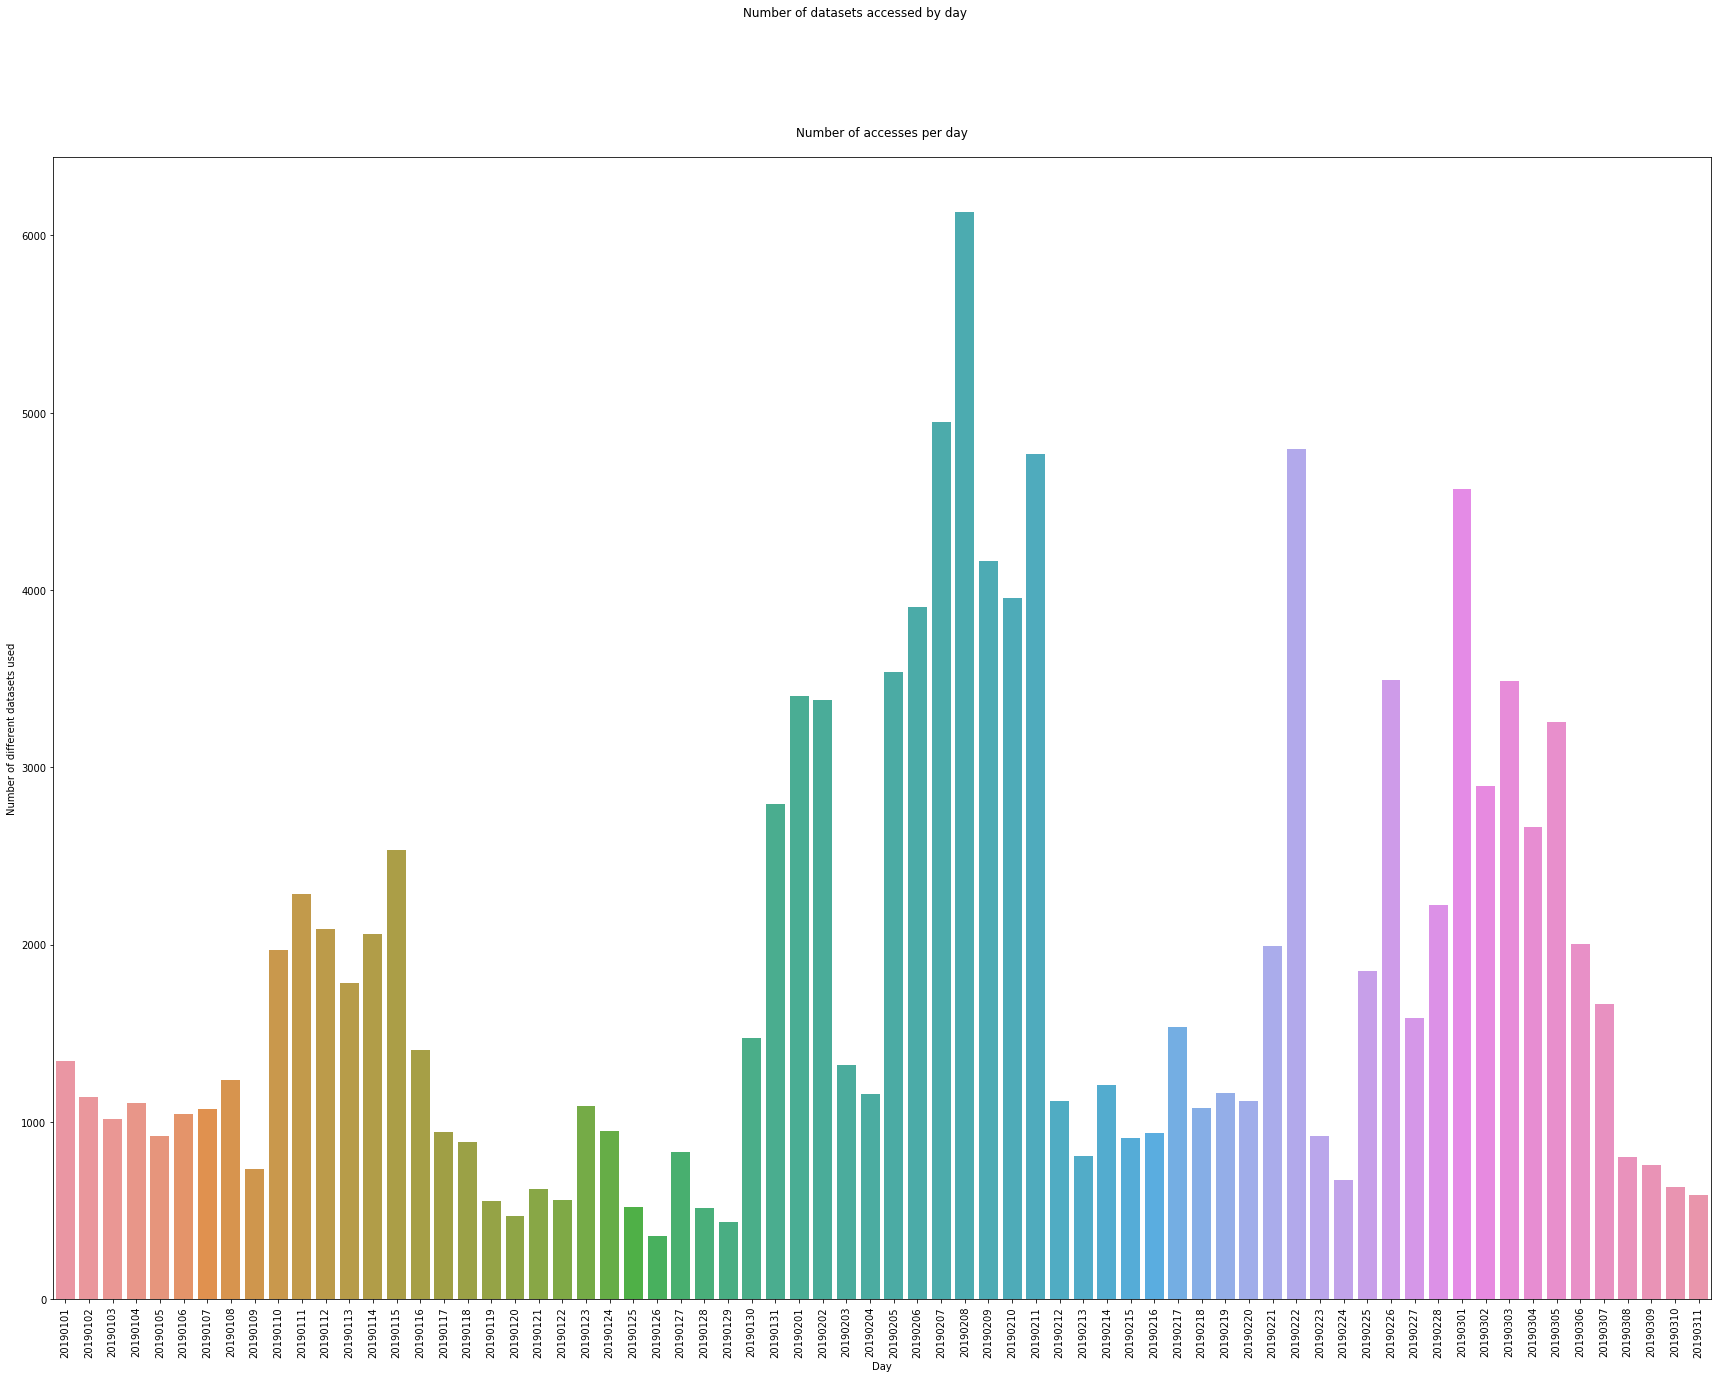

In [33]:
from matplotlib import pyplot
a4_dims = (29.7, 21.0)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.set_palette(sns.color_palette("Blues"))
plot = sns.barplot(x='day',y='count(DISTINCT d_dataset)',data=pdf)
pyplot.xlabel("Day")
pyplot.ylabel("Number of different datasets used")
pyplot.suptitle("Number of datasets accessed by day")
pyplot.title("""
Number of accesses per day
""")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Lists

The answer to the proposed requeriments are two lists. 
    - The first one is a list with datasets and their totals (Read and Written bytes, I/O times, and average size)
    - The second one is a list with files by day with application and nevents. 

In [34]:
grouped.show(5)

+--------------------+--------------------+--------+-------------+-------+-------------+----------+----------+--------+--------+
|           d_dataset|            file_lfn|     day|  application|nevents|     avg_size|  total_rb|  total_wb|total_rt|total_wt|
+--------------------+--------------------+--------+-------------+-------+-------------+----------+----------+--------+--------+
|/ZeroBias4/Run201...|/eos/cms/store/da...|20190211| eos/draining|      8| 3.65158474E8|1460633896|1460633896|   25132|     904|
|/ZeroBias4/Run201...|/eos/cms/store/da...|20190207|eos/balancing|      4| 1.93445658E8| 386891316| 386891316|     640|     232|
|/ZeroBias4/Run201...|/eos/cms/store/da...|20190207|eos/balancing|      4|  3.3260591E9|6652118200|6652118200|   11886|    8374|
|/WprimeToTBprimeJ...|/eos/cms/store/mc...|20190303|  eos/gridftp|      4|2.591004126E9|         0|5182008252|       0|    6560|
|/DoubleMuonLowMas...|/eos/cms/store/da...|20190217|  eos/gridftp|      4|2.026766421E9|         

In [35]:
grouped.registerTempTable('_grouped')
_datasets_totals = spark.sql('''
SELECT d_dataset, sum(nevents) as nevents, sum(avg_size*nevents)/sum(nevents) as avg_size, sum(total_rb) as total_rb, sum(total_wb) as total_wb, sum(total_rt) as total_rt, sum(total_wt) as total_wt
from _grouped group by d_dataset''').toPandas()

In [36]:
_datasets_totals.to_csv('dataset_summary.csv')

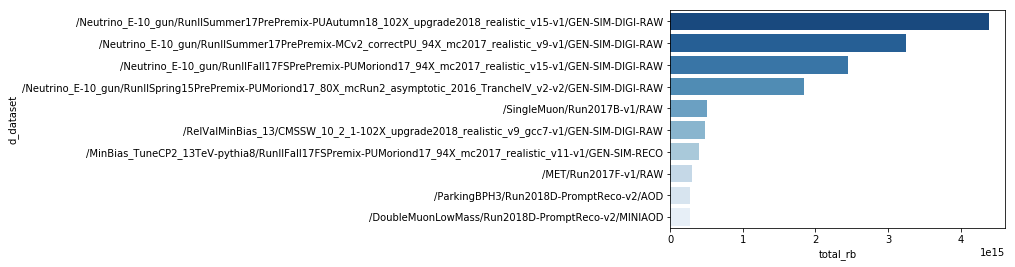

In [37]:
top_dataset_by_rb = _datasets_totals.sort_values('total_rb',ascending=False).head(10)
palette=sns.color_palette('Blues',n_colors=10)
palette.reverse()
sns.set_palette(palette)
#sns.palplot(sns.color_palette('Blues', n_colors=10))
sns.barplot(y='d_dataset',x='total_rb',data=top_dataset_by_rb)


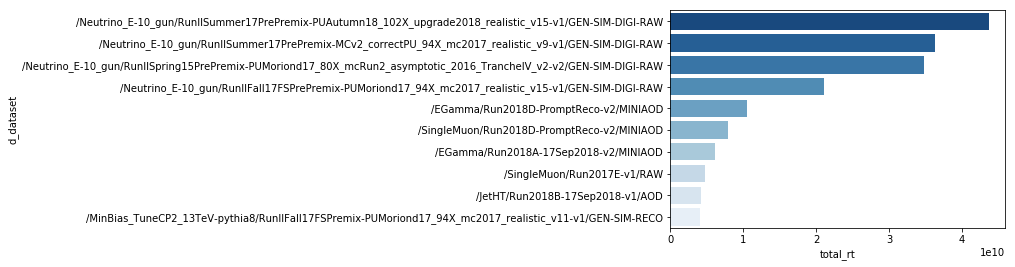

In [38]:
top_dataset_by_rt = _datasets_totals.sort_values('total_rt',ascending=False).head(10)
sns.barplot(y='d_dataset',x='total_rt',data=top_dataset_by_rt)

In [39]:
grouped.write.option('header','true').mode('overwrite').csv('salidaEOS') # -saves to hdfs- maybe it not make sense to download all the data (filter list by app?)